# Personalized Drug Response Prediction

This project aims to predict personalized drug responses using patient-specific features such as genetic markers, demographics, and drug properties.

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


In [90]:
warnings.filterwarnings("ignore")

In [91]:
# Drug response data (IC50)
gd1 = pd.read_csv("/kaggle/input/drugggg/PANCANCER_IC_Tue Jul  8 10_28_03 2025.csv");
gd2 = pd.read_csv("/kaggle/input/drugggg/PANCANCER_IC_Tue Jul  8 10_28_11 2025.csv")

# Cell line annotations
cl1 = pd.read_excel("/kaggle/input/drugggg/Cell_Lines_Details.xlsx")
cl2 = pd.read_excel("/kaggle/input/drugggg/TableS1E.xlsx")

sc = pd.read_csv("/kaggle/input/drugggg/screened_compounds_rel_8.5.csv")

exp = pd.read_csv("/kaggle/input/drugggg2/Expression_Public_25Q2_subsetted.csv")

homu = pd.read_csv("/kaggle/input/drugggg2/Hotspot_Mutations_subsetted.csv")

mut = pd.read_csv("/kaggle/input/mutations/mutations_all_20250318.csv")

In [92]:
gd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333292 entries, 0 to 333291
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Drug Name            333292 non-null  object 
 1   Drug ID              333292 non-null  int64  
 2   Cell Line Name       333292 non-null  object 
 3   Cosmic ID            333292 non-null  int64  
 4   TCGA Classification  332712 non-null  object 
 5   Tissue               333292 non-null  object 
 6   Tissue Sub-type      333292 non-null  object 
 7   IC50                 333292 non-null  float64
 8   AUC                  333292 non-null  float64
 9   Max Conc             333292 non-null  float64
 10  RMSE                 333292 non-null  float64
 11  Z score              333292 non-null  float64
 12  Dataset Version      333292 non-null  object 
dtypes: float64(5), int64(2), object(6)
memory usage: 33.1+ MB


🔹 Basic Info
<class 'pandas.core.frame.DataFrame'>
Index: 269241 entries, 0 to 333291
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Drug Name            269241 non-null  object 
 1   Drug ID              269241 non-null  int64  
 2   Cell Line Name       269241 non-null  object 
 3   Cosmic ID            269241 non-null  int64  
 4   TCGA Classification  269241 non-null  object 
 5   Tissue               269241 non-null  object 
 6   Tissue Sub-type      269241 non-null  object 
 7   IC50                 269241 non-null  float64
 8   AUC                  269241 non-null  float64
 9   Max Conc             269241 non-null  float64
 10  RMSE                 269241 non-null  float64
 11  Z score              269241 non-null  float64
 12  Dataset Version      269241 non-null  object 
 13  log_IC50             269241 non-null  float64
 14  cell_key             269241 non-null  int64  
dtypes: float6

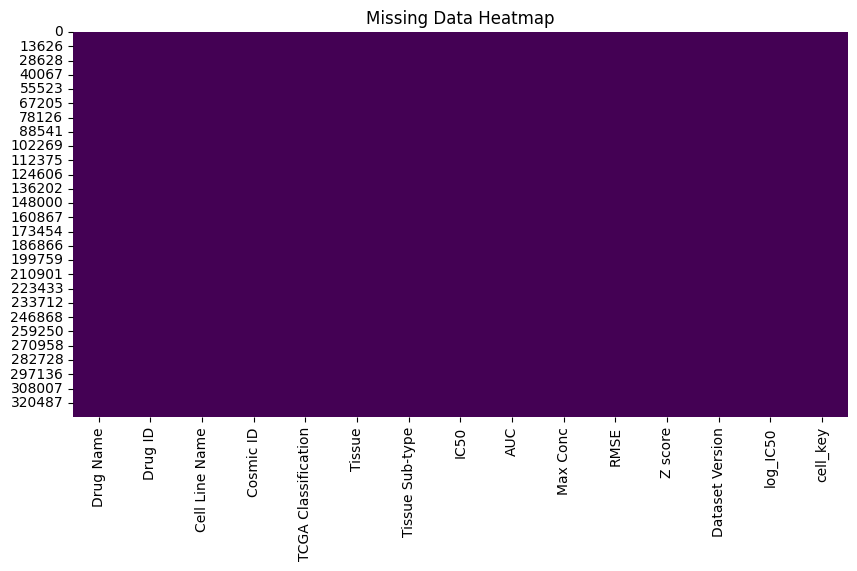

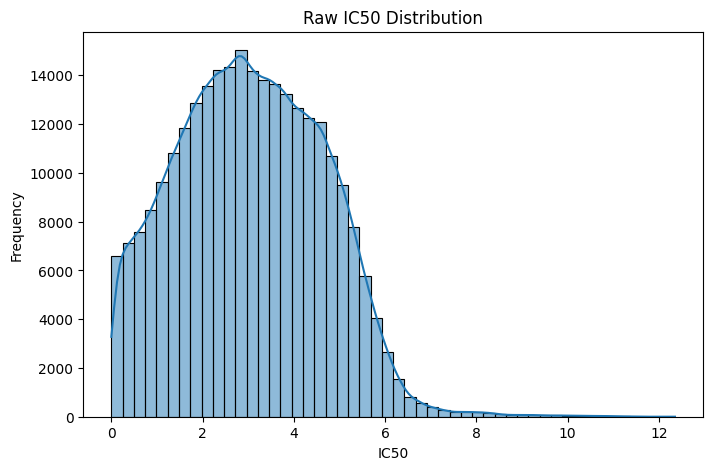

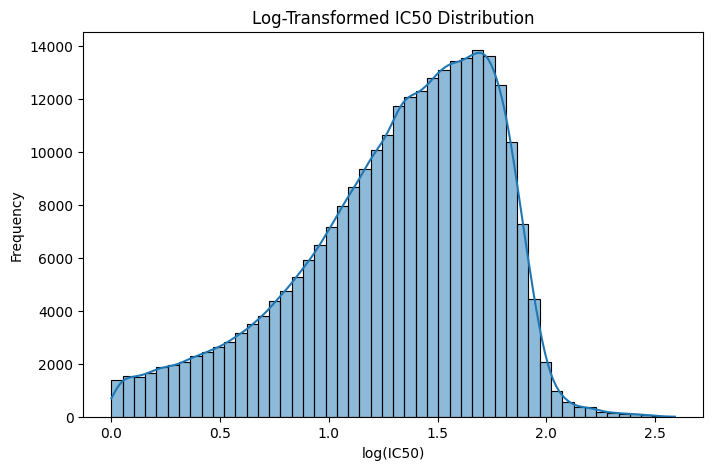

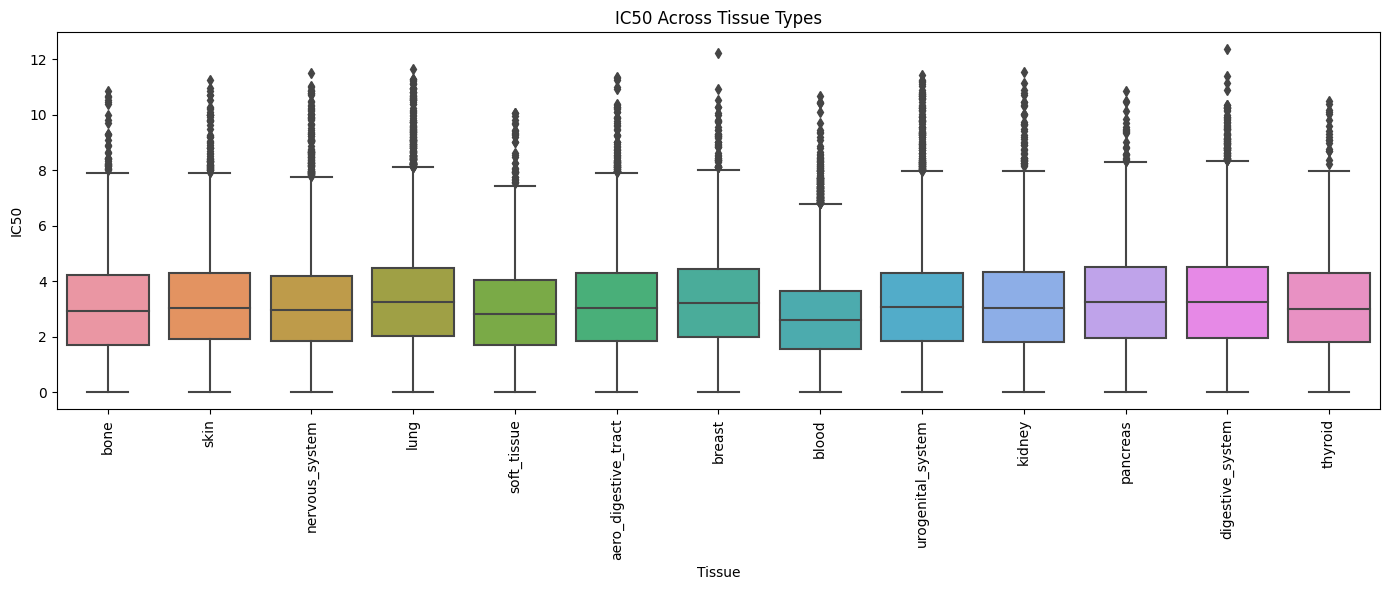

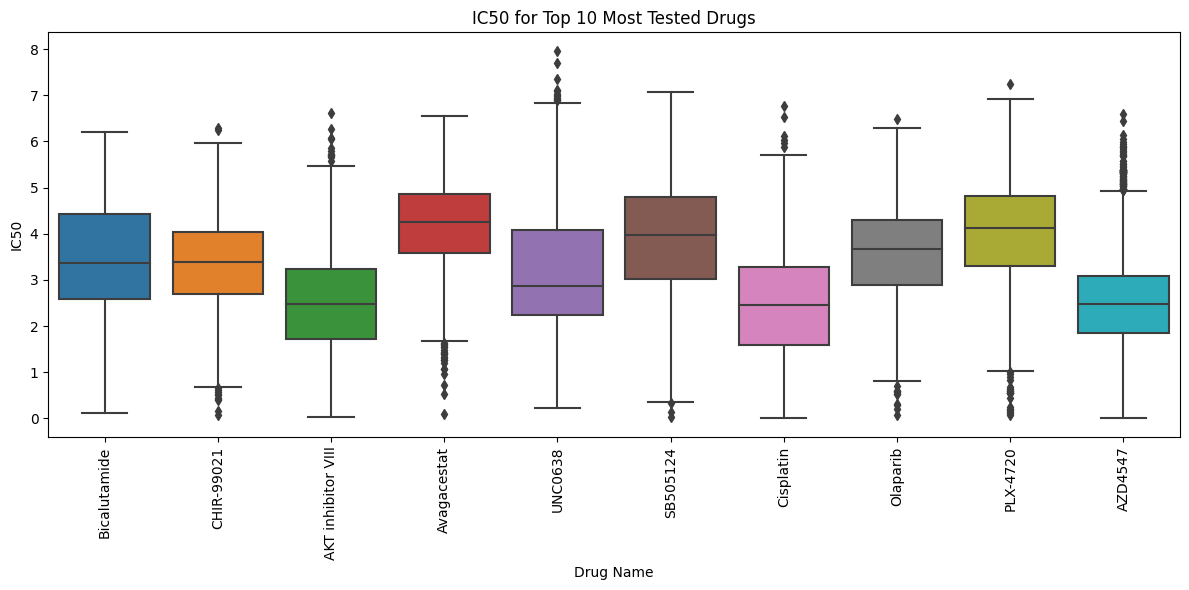

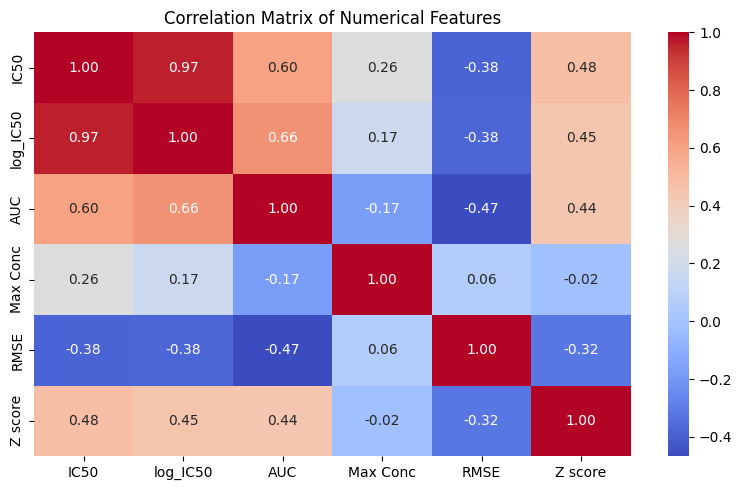

✅ Final Cleaned gd1 Shape: (269241, 15)


In [93]:
# 🔹 Keep only necessary columns
gd1 = gd1[[
    'Drug Name', 'Drug ID', 'Cell Line Name', 'Cosmic ID',
    'TCGA Classification', 'Tissue', 'Tissue Sub-type',
    'IC50', 'AUC', 'Max Conc', 'RMSE', 'Z score', 'Dataset Version'
]]
 
# 🔹 Drop missing values from important columns
gd1 = gd1.dropna(subset=["IC50", "TCGA Classification", "Cell Line Name", "Cosmic ID"])
 
# 🔹 Remove rows with IC50 <= 0 (invalid for log1p)
gd1 = gd1[gd1["IC50"] > 0]
 
# 🔹 Create log-transformed IC50
gd1["log_IC50"] = np.log1p(gd1["IC50"])
 
# 🔹 Clean text columns
gd1["Cell Line Name"] = gd1["Cell Line Name"].str.strip().str.lower()
gd1["Tissue"] = gd1["Tissue"].str.strip().str.lower()
gd1["TCGA Classification"] = gd1["TCGA Classification"].str.strip().str.upper()
 
# 🔹 Create a consistent key to join with expression/mutation datasets
gd1["cell_key"] = gd1["Cosmic ID"]
 
# ============================
# 🔍 EDA STARTS HERE
# ============================
 
# 1. Overview
print("🔹 Basic Info")
print(gd1.info())
print("\n🔹 Summary Statistics")
print(gd1.describe())
 
# 2. Unique values
print("\n🔹 Unique Counts")
print("Unique Drugs:", gd1["Drug Name"].nunique())
print("Unique Cell Lines:", gd1["Cell Line Name"].nunique())
print("Unique Tissues:", gd1["Tissue"].nunique())
 
# 3. Missing data heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(gd1.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()
 
# 4. IC50 Distribution
plt.figure(figsize=(8, 5))
sns.histplot(gd1["IC50"], kde=True, bins=50)
plt.title("Raw IC50 Distribution")
plt.xlabel("IC50")
plt.ylabel("Frequency")
plt.show()
 
# 5. Log-IC50 Distribution
plt.figure(figsize=(8, 5))
sns.histplot(gd1["log_IC50"], kde=True, bins=50)
plt.title("Log-Transformed IC50 Distribution")
plt.xlabel("log(IC50)")
plt.ylabel("Frequency")
plt.show()
 
# 6. IC50 by Tissue
plt.figure(figsize=(14, 6))
sns.boxplot(x="Tissue", y="IC50", data=gd1)
plt.xticks(rotation=90)
plt.title("IC50 Across Tissue Types")
plt.tight_layout()
plt.show()
 
# 7. IC50 by Drug
top_10_drugs = gd1["Drug Name"].value_counts().nlargest(10).index.tolist()
plt.figure(figsize=(12, 6))
sns.boxplot(x="Drug Name", y="IC50", data=gd1[gd1["Drug Name"].isin(top_10_drugs)])
plt.xticks(rotation=90)
plt.title("IC50 for Top 10 Most Tested Drugs")
plt.tight_layout()
plt.show()
 
# 8. Correlation matrix
plt.figure(figsize=(8, 5))
corr = gd1[["IC50", "log_IC50", "AUC", "Max Conc", "RMSE", "Z score"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()
 
# 9. Final shape
print(f"✅ Final Cleaned gd1 Shape: {gd1.shape}")

In [94]:
gd1.tail(20)

,Drug Name,Drug ID,Cell Line Name,Cosmic ID,TCGA Classification,Tissue,Tissue Sub-type,IC50,AUC,Max Conc,RMSE,Z score,Dataset Version,log_IC50,cell_key
333272,I-CBP112,1531,eso26,1503366,ESCA,aero_digestive_tract,oesophagus,4.810052,0.986740,10.0,0.025473,0.462891,GDSC1,1.759590,1503366
333273,I-CBP112,1531,eso51,1503367,ESCA,aero_digestive_tract,oesophagus,5.420367,0.977101,10.0,0.072332,1.344820,GDSC1,1.859475,1503367
333274,I-CBP112,1531,kyae-1,1503368,ESCA,aero_digestive_tract,oesophagus,4.461081,0.978863,10.0,0.031596,-0.041387,GDSC1,1.697647,1503368
333275,I-CBP112,1531,emc-bac-1,1503369,LUAD,lung,lung_NSCLC_adenocarcinoma,5.060163,0.978574,10.0,0.042571,0.824310,GDSC1,1.801737,1503369
333276,I-CBP112,1531,emc-bac-2,1503370,LUAD,lung,lung_NSCLC_adenocarcinoma,4.050714,0.961589,10.0,0.071150,-0.634382,GDSC1,1.619530,1503370
333277,I-CBP112,1531,te-4,1503371,ESCA,aero_digestive_tract,oesophagus,4.524654,0.986404,10.0,0.080202,0.050479,GDSC1,1.709221,1503371
333278,I-CBP112,1531,ncc010,1509073,KIRC,kidney,kidney,4.617198,0.978494,10.0,0.095539,0.184209,GDSC1,1.725833,1509073
333279,I-CBP112,1531,ncc021,1509074,KIRC,kidney,kidney,4.451314,0.974422,10.0,0.029674,-0.055500,GDSC1,1.695857,1509074
333280,I-CBP112,1531,rcc-fg2,1524414,KIRC,kidney,kidney,5.140318,0.978136,10.0,0.042883,0.940137,GDSC1,1.814877,1524414
333281,I-CBP112,1531,rcc-jf,1524415,KIRC,kidney,kidney,4.798095,0.980377,10.0,0.044352,0.445612,GDSC1,1.757529,1524415


In [95]:
gd2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243466 entries, 0 to 243465
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Drug Name            243466 non-null  object 
 1   Drug ID              243466 non-null  int64  
 2   Cell Line Name       243466 non-null  object 
 3   Cosmic ID            243466 non-null  int64  
 4   TCGA Classification  242399 non-null  object 
 5   Tissue               243107 non-null  object 
 6   Tissue Sub-type      243107 non-null  object 
 7   IC50                 243466 non-null  float64
 8   AUC                  243466 non-null  float64
 9   Max Conc             243466 non-null  float64
 10  RMSE                 243466 non-null  float64
 11  Z score              243466 non-null  float64
 12  Dataset Version      243466 non-null  object 
dtypes: float64(5), int64(2), object(6)
memory usage: 24.1+ MB


🔹 gd2 Info
<class 'pandas.core.frame.DataFrame'>
Index: 208365 entries, 22 to 243465
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Drug Name            208365 non-null  object 
 1   Drug ID              208365 non-null  int64  
 2   Cell Line Name       208365 non-null  object 
 3   Cosmic ID            208365 non-null  int64  
 4   TCGA Classification  208365 non-null  object 
 5   Tissue               208365 non-null  object 
 6   Tissue Sub-type      208365 non-null  object 
 7   IC50                 208365 non-null  float64
 8   AUC                  208365 non-null  float64
 9   Max Conc             208365 non-null  float64
 10  RMSE                 208365 non-null  float64
 11  Z score              208365 non-null  float64
 12  Dataset Version      208365 non-null  object 
 13  log_IC50             208365 non-null  float64
 14  cell_key             208365 non-null  int64  
dtypes: float64

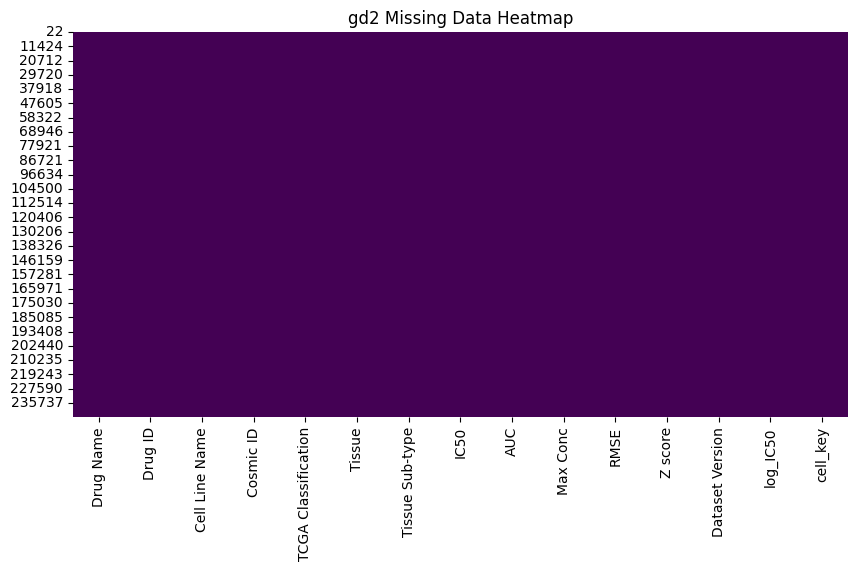

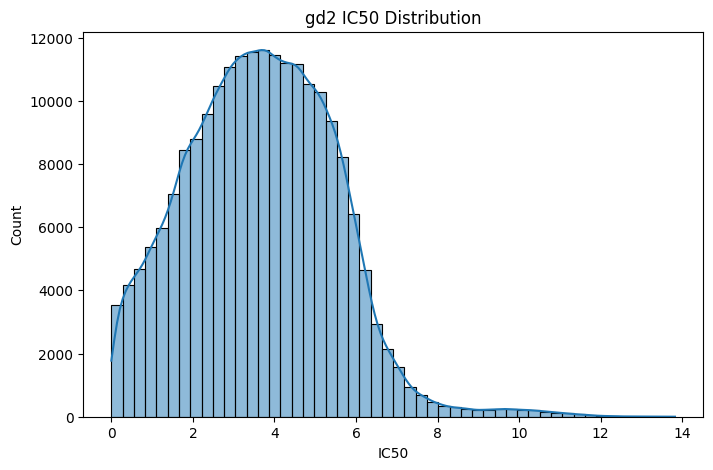

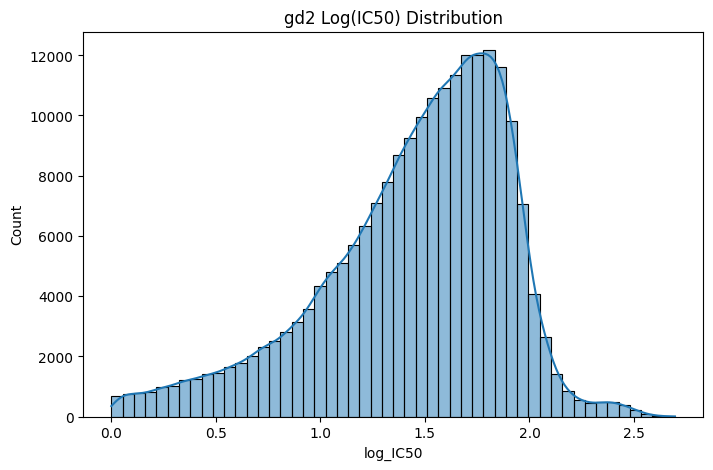

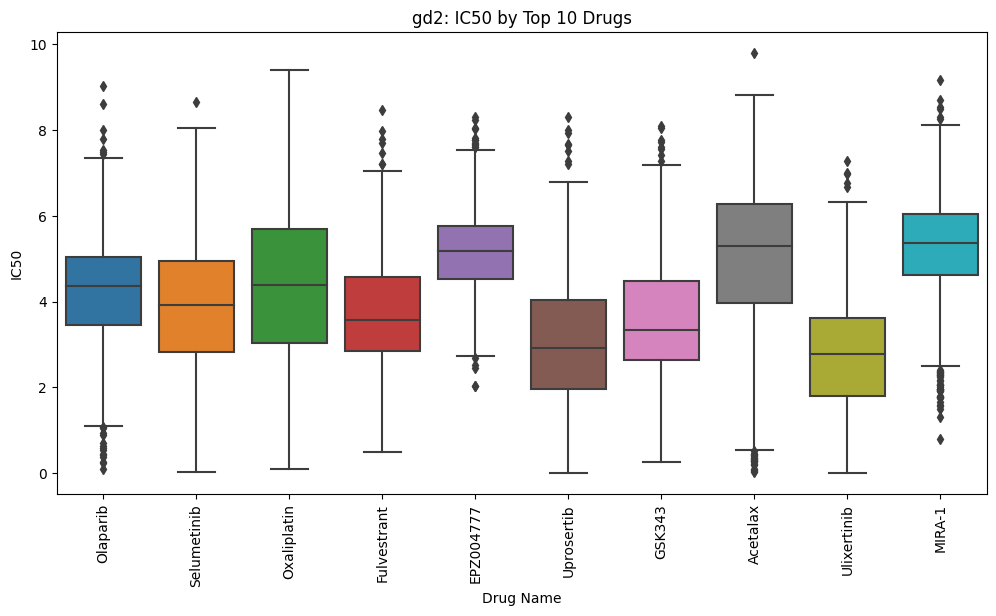

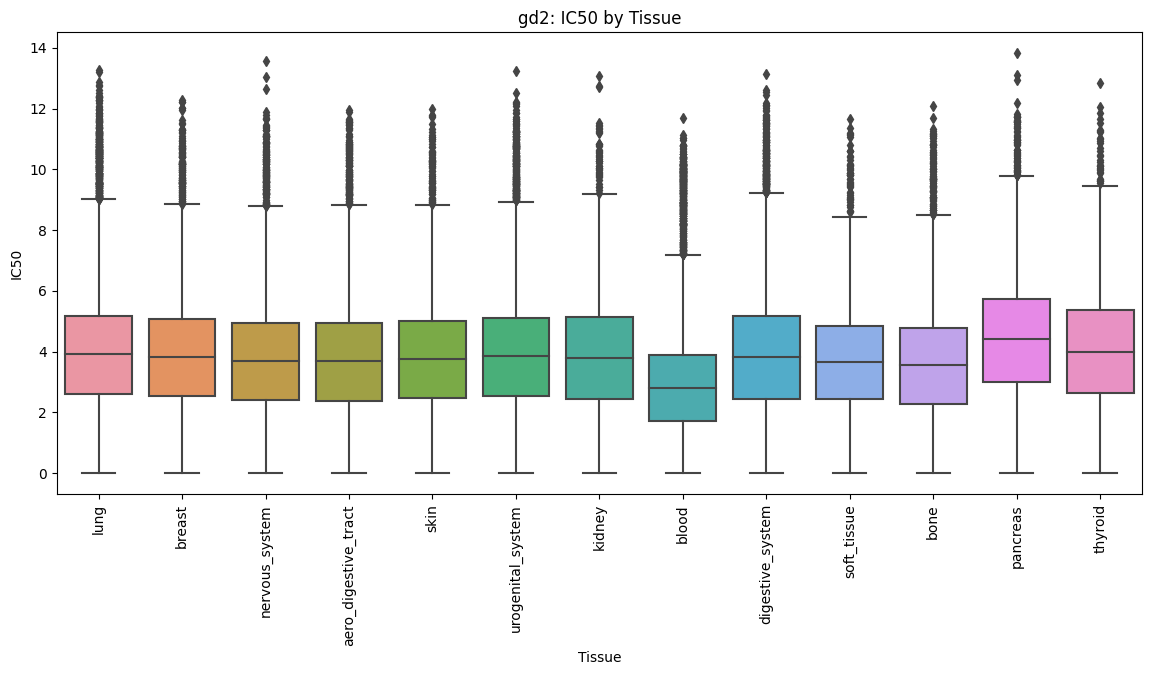

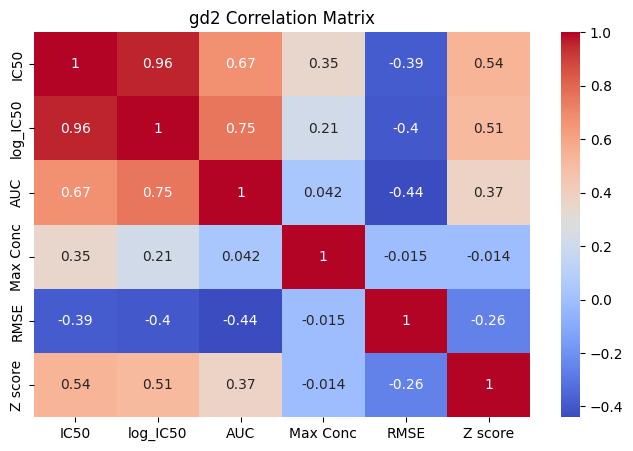

✅ Final gd2 Shape: (208365, 15)


In [96]:
# Keep only essential columns
gd2 = gd2[[
    'Drug Name', 'Drug ID', 'Cell Line Name', 'Cosmic ID',
    'TCGA Classification', 'Tissue', 'Tissue Sub-type',
    'IC50', 'AUC', 'Max Conc', 'RMSE', 'Z score', 'Dataset Version'
]]
 
# Drop rows where key columns are missing
gd2 = gd2.dropna(subset=["IC50", "TCGA Classification", "Cell Line Name", "Cosmic ID"])
 
# Filter out invalid IC50 values (≤ 0)
gd2 = gd2[gd2["IC50"] > 0]
 
# Log-transform IC50
gd2["log_IC50"] = np.log1p(gd2["IC50"])
 
# Clean text fields
gd2["Cell Line Name"] = gd2["Cell Line Name"].str.lower().str.strip()
gd2["Tissue"] = gd2["Tissue"].str.lower().str.strip()
gd2["TCGA Classification"] = gd2["TCGA Classification"].str.upper().str.strip()
 
# Add join key
gd2["cell_key"] = gd2["Cosmic ID"]
 
# ===== EDA =====
 
print("🔹 gd2 Info")
print(gd2.info())
 
print("\n🔹 Summary Statistics")
print(gd2.describe())
 
print("\n🔹 Unique counts:")
print("Unique Drugs:", gd2["Drug Name"].nunique())
print("Unique Cell Lines:", gd2["Cell Line Name"].nunique())
print("Unique Tissues:", gd2["Tissue"].nunique())
 
# Missing data heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(gd2.isnull(), cbar=False, cmap="viridis")
plt.title("gd2 Missing Data Heatmap")
plt.show()
 
# Raw IC50 distribution
plt.figure(figsize=(8, 5))
sns.histplot(gd2["IC50"], kde=True, bins=50)
plt.title("gd2 IC50 Distribution")
plt.show()
 
# Log-IC50 distribution
plt.figure(figsize=(8, 5))
sns.histplot(gd2["log_IC50"], kde=True, bins=50)
plt.title("gd2 Log(IC50) Distribution")
plt.show()
 
# Top 10 drugs — IC50 boxplot
top_drugs = gd2["Drug Name"].value_counts().nlargest(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(x="Drug Name", y="IC50", data=gd2[gd2["Drug Name"].isin(top_drugs)])
plt.xticks(rotation=90)
plt.title("gd2: IC50 by Top 10 Drugs")
plt.show()
 
# Tissue-wise IC50
plt.figure(figsize=(14, 6))
sns.boxplot(x="Tissue", y="IC50", data=gd2)
plt.xticks(rotation=90)
plt.title("gd2: IC50 by Tissue")
plt.show()
 
# Correlation heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(gd2[["IC50", "log_IC50", "AUC", "Max Conc", "RMSE", "Z score"]].corr(), annot=True, cmap="coolwarm")
plt.title("gd2 Correlation Matrix")
plt.show()
 
# Final shape
print(f"✅ Final gd2 Shape: {gd2.shape}")

In [97]:
# Make sure both are in the same format
common_cols = list(set(gd1.columns).intersection(set(gd2.columns)))
 
# Combine gd1 and gd2
gdf = pd.concat([gd1[common_cols], gd2[common_cols]], ignore_index=True)
 
# Optional: Reset index
gdf = gdf.reset_index(drop=True)
 
# Check result
print("✅ Combined gdf shape:", gdf.shape)
print(gdf["Dataset Version"].value_counts())  # GDSC1 vs GDSC2 counts

✅ Combined gdf shape: (477606, 15)
Dataset Version
GDSC1    269241
GDSC2    208365
Name: count, dtype: int64


In [98]:
# Check for duplicate cell line + drug pairs
dup = gdf.duplicated(subset=["Drug Name", "Cell Line Name", "Cosmic ID"])
print("🔁 Duplicate Rows:", dup.sum())
 
# Unique drug count
print("🧪 Unique drugs:", gdf["Drug Name"].nunique())
print("🧬 Unique cell lines:", gdf["Cell Line Name"].nunique())

🔁 Duplicate Rows: 85734
🧪 Unique drugs: 542
🧬 Unique cell lines: 971


In [99]:
# ✅ Step 1: Define columns
group_keys = [
    "Drug Name", "Drug ID", "Cell Line Name", "Cosmic ID",
    "TCGA Classification", "Tissue", "Tissue Sub-type"
]
 
agg_columns = ["IC50", "log_IC50", "AUC", "Max Conc", "RMSE", "Z score"]
 
# ✅ Step 2: Perform aggregation (average values, keep one dataset version)
gdf_avg = gdf.groupby(group_keys).agg(
    {**{col: "mean" for col in agg_columns}, "Dataset Version": "first"}
).reset_index()
 
# ✅ Step 3: Add cell_key for joining with gene expression/mutations
gdf_avg["cell_key"] = gdf_avg["Cosmic ID"]
 
# ✅ Step 4: Optional sorting
gdf_avg = gdf_avg.sort_values(by="IC50").reset_index(drop=True)
 
# ✅ Step 5: Validate result
print("✅ gdf_avg shape:", gdf_avg.shape)
print("🔁 Any duplicates left?:", gdf_avg.duplicated(subset=["Drug Name", "Cell Line Name", "Cosmic ID"]).sum())
 

✅ gdf_avg shape: (433045, 15)
🔁 Any duplicates left?: 41173


In [100]:
# Drop remaining duplicates after averaging
gdf_final = gdf_avg.drop_duplicates(subset=["Drug Name", "Cell Line Name", "Cosmic ID"], keep="first")
 
# Reset index just for neatness
gdf_final = gdf_final.reset_index(drop=True)
 
# Final check
print("✅ Final shape after dropping all duplicates:", gdf_final.shape)
print("🔁 Duplicates now:", gdf_final.duplicated(subset=["Drug Name", "Cell Line Name", "Cosmic ID"]).sum())
 

✅ Final shape after dropping all duplicates: (391872, 15)
🔁 Duplicates now: 0


In [101]:
gdf = gdf_final
gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391872 entries, 0 to 391871
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Drug Name            391872 non-null  object 
 1   Drug ID              391872 non-null  int64  
 2   Cell Line Name       391872 non-null  object 
 3   Cosmic ID            391872 non-null  int64  
 4   TCGA Classification  391872 non-null  object 
 5   Tissue               391872 non-null  object 
 6   Tissue Sub-type      391872 non-null  object 
 7   IC50                 391872 non-null  float64
 8   log_IC50             391872 non-null  float64
 9   AUC                  391872 non-null  float64
 10  Max Conc             391872 non-null  float64
 11  RMSE                 391872 non-null  float64
 12  Z score              391872 non-null  float64
 13  Dataset Version      391872 non-null  object 
 14  cell_key             391872 non-null  int64  
dtypes: float64(6), in

In [102]:
cl1.head()

,Sample Name,COSMIC identifier,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
0,A253,906794.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
1,BB30-HNC,753531.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
2,BB49-HNC,753532.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
3,BHY,753535.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
4,BICR10,1290724.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent


In [103]:
cl1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Sample Name                               1002 non-null   object 
 1   COSMIC identifier                         1001 non-null   float64
 2   Whole Exome Sequencing (WES)              1002 non-null   object 
 3   Copy Number Alterations (CNA)             1002 non-null   object 
 4   Gene Expression                           1002 non-null   object 
 5   Methylation                               1002 non-null   object 
 6   Drug
Response                             1002 non-null   object 
 7   GDSC
Tissue descriptor 1                  1001 non-null   object 
 8   GDSC
Tissue
descriptor 2                  1001 non-null   object 
 9   Cancer Type
(matching TCGA label)         826 non-null    object 
 10  Microsatellite 
instability Status (

In [104]:
# ✅ Rename columns for clarity
cl1.columns = [
    "Sample_Name",            # 0
    "COSMIC_ID",              # 1
    "WES",                    # 2 - Whole Exome Sequencing
    "CNA",                    # 3 - Copy Number Alteration
    "Gene_Expression",        # 4
    "Methylation",            # 5
    "Drug_Response",          # 6
    "Tissue_Descriptor_1",    # 7
    "Tissue_Descriptor_2",    # 8
    "Cancer_Type_TCGA",       # 9
    "MSI_Status",             # 10
    "Screen_Medium",          # 11
    "Growth_Properties"       # 12
]
 
# # ✅ Basic EDA
# print("📊 Shape:", cl1.shape)
# print("\n🔍 Missing Values:\n", cl1.isnull().sum())
# print("\n📌 Unique Tissues:", cl1["Tissue_Descriptor_1"].nunique())
# print("📌 Unique TCGA Types:", cl1["Cancer_Type_TCGA"].nunique())

In [105]:
cl1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sample_Name          1002 non-null   object 
 1   COSMIC_ID            1001 non-null   float64
 2   WES                  1002 non-null   object 
 3   CNA                  1002 non-null   object 
 4   Gene_Expression      1002 non-null   object 
 5   Methylation          1002 non-null   object 
 6   Drug_Response        1002 non-null   object 
 7   Tissue_Descriptor_1  1001 non-null   object 
 8   Tissue_Descriptor_2  1001 non-null   object 
 9   Cancer_Type_TCGA     826 non-null    object 
 10  MSI_Status           986 non-null    object 
 11  Screen_Medium        1001 non-null   object 
 12  Growth_Properties    999 non-null    object 
dtypes: float64(1), object(12)
memory usage: 101.9+ KB


In [106]:

# ✅ Step 2: Basic EDA
print("📊 Shape:", cl1.shape)
print("\n🔍 Nulls:\n", cl1.isnull().sum())
 
# ✅ Step 3: Drop rows with null COSMIC_ID (can't merge without it)
cl1 = cl1.dropna(subset=["COSMIC_ID"]).copy()
 
# ✅ Step 4: Convert COSMIC_ID to integer (after dropping NaN)
cl1["COSMIC_ID"] = cl1["COSMIC_ID"].astype(int)
 
# ✅ Step 5: Standardize text fields
for col in ["Sample_Name", "Tissue_Descriptor_1", "Tissue_Descriptor_2", "Cancer_Type_TCGA", "Screen_Medium", "Growth_Properties"]:
    cl1[col] = cl1[col].astype(str).str.strip().str.upper()
 
# ✅ Step 6: Fill missing Cancer Type (safe fallback)
cl1["Cancer_Type_TCGA"] = cl1["Cancer_Type_TCGA"].fillna("UNKNOWN")
 
# ✅ Step 7: Binary MSI_High feature from MSI_Status
cl1["MSI_High"] = cl1["MSI_Status"].apply(
    lambda x: 1 if isinstance(x, str) and "MSI" in x.upper() and "HIGH" in x.upper() else 0
)
 
# ✅ Step 8: Create merge key
cl1["cell_key"] = cl1["COSMIC_ID"]
 
# ✅ Step 9: Final selected features for modeling/merge
cl1_final = cl1[[
    "cell_key", "Sample_Name", "Cancer_Type_TCGA", "MSI_High",
    "Tissue_Descriptor_1", "Tissue_Descriptor_2",
    "Growth_Properties", "Screen_Medium"
]]
 
# ✅ Summary
print("\n✅ Final cl1_final shape:", cl1_final.shape)
print("🧬 Unique cell lines:", cl1_final['cell_key'].nunique())
print("🧩 Final columns:\n", cl1_final.columns.tolist())
 

📊 Shape: (1002, 13)

🔍 Nulls:
 Sample_Name              0
COSMIC_ID                1
WES                      0
CNA                      0
Gene_Expression          0
Methylation              0
Drug_Response            0
Tissue_Descriptor_1      1
Tissue_Descriptor_2      1
Cancer_Type_TCGA       176
MSI_Status              16
Screen_Medium            1
Growth_Properties        3
dtype: int64

✅ Final cl1_final shape: (1001, 8)
🧬 Unique cell lines: 1001
🧩 Final columns:
 ['cell_key', 'Sample_Name', 'Cancer_Type_TCGA', 'MSI_High', 'Tissue_Descriptor_1', 'Tissue_Descriptor_2', 'Growth_Properties', 'Screen_Medium']


In [107]:
cl1 = cl1_final

cl1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1001 entries, 0 to 1000
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   cell_key             1001 non-null   int64 
 1   Sample_Name          1001 non-null   object
 2   Cancer_Type_TCGA     1001 non-null   object
 3   MSI_High             1001 non-null   int64 
 4   Tissue_Descriptor_1  1001 non-null   object
 5   Tissue_Descriptor_2  1001 non-null   object
 6   Growth_Properties    1001 non-null   object
 7   Screen_Medium        1001 non-null   object
dtypes: int64(2), object(6)
memory usage: 70.4+ KB


In [108]:
gdf.head(10)

,Drug Name,Drug ID,Cell Line Name,Cosmic ID,TCGA Classification,Tissue,Tissue Sub-type,IC50,log_IC50,AUC,Max Conc,RMSE,Z score,Dataset Version,cell_key
0,Capivasertib,1136,eol-1-cell,906856,UNCLASSIFIED,blood,haematopoietic_neoplasm_other,0.000008,0.000008,0.397873,30.000,0.042747,-1.743871,GDSC1,906856
1,rTRAIL,1261,rf-48,909697,STAD,digestive_system,stomach,0.000013,0.000013,0.968823,0.100,0.112718,0.571309,GDSC1,909697
2,I-BET-762,1624,nci-h929,724825,MM,blood,myeloma,0.000031,0.000031,0.654001,10.000,0.111164,-2.012098,GDSC2,724825
3,Bleomycin,1812,sk-co-1,909718,COREAD,digestive_system,large_intestine,0.000032,0.000032,0.805522,2.000,0.048442,-1.845651,GDSC2,909718
4,GW843682X,87,nci-h23,905942,LUAD,lung,lung_NSCLC_adenocarcinoma,0.000119,0.000119,0.964308,0.256,0.086574,1.337625,GDSC1,905942
5,Buparlisib,1873,jiyoyep-2003,907268,UNCLASSIFIED,blood,Burkitt_lymphoma,0.000147,0.000147,0.653081,10.000,0.078603,-1.203632,GDSC2,907268
6,JNK-9L,157,nci-h1755,908475,LUAD,lung,lung_NSCLC_adenocarcinoma,0.000172,0.000172,0.670225,5.120,0.228113,0.254887,GDSC1,908475
7,Dasatinib,1079,nk-92mi,1330981,UNCLASSIFIED,blood,lymphoid_neoplasm_other,0.000283,0.000283,0.873009,2.000,0.173486,-0.553947,GDSC2,1330981
8,ZG-10,1161,flo-1,1503361,ESCA,aero_digestive_tract,oesophagus,0.000317,0.000317,0.562483,10.000,0.092513,-1.261036,GDSC1,1503361
9,Epirubicin,1511,scc-15,910911,HNSC,aero_digestive_tract,head_and_neck,0.000428,0.000428,0.853332,1.000,0.077266,0.564845,GDSC2,910911


In [109]:
cl1.head(10)

,cell_key,Sample_Name,Cancer_Type_TCGA,MSI_High,Tissue_Descriptor_1,Tissue_Descriptor_2,Growth_Properties,Screen_Medium
0,906794,A253,NAN,0,AERO_DIG_TRACT,HEAD AND NECK,ADHERENT,D/F12
1,753531,BB30-HNC,HNSC,0,AERO_DIG_TRACT,HEAD AND NECK,ADHERENT,D/F12
2,753532,BB49-HNC,HNSC,0,AERO_DIG_TRACT,HEAD AND NECK,ADHERENT,D/F12
3,753535,BHY,HNSC,0,AERO_DIG_TRACT,HEAD AND NECK,ADHERENT,D/F12
4,1290724,BICR10,HNSC,0,AERO_DIG_TRACT,HEAD AND NECK,ADHERENT,D/F12
5,1240121,BICR22,HNSC,0,AERO_DIG_TRACT,HEAD AND NECK,ADHERENT,D/F12
6,1290725,BICR31,HNSC,0,AERO_DIG_TRACT,HEAD AND NECK,ADHERENT,D/F12
7,1240122,BICR78,HNSC,0,AERO_DIG_TRACT,HEAD AND NECK,ADHERENT,D/F12
8,753538,CA9-22,HNSC,0,AERO_DIG_TRACT,HEAD AND NECK,ADHERENT,D/F12
9,910916,CAL-27,HNSC,0,AERO_DIG_TRACT,HEAD AND NECK,ADHERENT,D/F12


In [110]:
cl2.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,NaN,Table S1E - List cell line samples with annota...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Sample Name,COSMIC identifier,Available Data ? (Y)es or (N)o,NaN,NaN,NaN,NaN,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite (MS)\ninstability (I) Status\n=...,Screen Medium\n(legend to be added),Growth Properties
2,NaN,NaN,NaN,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,A253,906794,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
4,NaN,BB30-HNC,753531,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
5,NaN,BB49-HNC,753532,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
6,NaN,BHY,753535,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
7,NaN,BICR10,1290724,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
8,NaN,BICR22,1240121,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
9,NaN,BICR31,1290725,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent


In [111]:
# Remove the first column
cl2 = cl2.iloc[:, 1:]

# Remove the first 3 rows
cl2 = cl2.iloc[3:].reset_index(drop=True)

In [112]:
cl2.head(10)

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,A253,906794,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
1,BB30-HNC,753531,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
2,BB49-HNC,753532,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
3,BHY,753535,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
4,BICR10,1290724,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
5,BICR22,1240121,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
6,BICR31,1290725,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
7,BICR78,1240122,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
8,Ca9-22,753538,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
9,CAL-27,910916,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent


In [113]:
# Assuming cl2 is your DataFrame
cl2.columns = [
    'Sample Name',
    'COSMIC identifier',
    'Whole Exome Sequencing (WES)',
    'Copy Number Alterations (CNA)',
    'Gene Expression',
    'Methylation',
    'Drug Response',
    'GDSC Tissue descriptor 1',
    'GDSC Tissue descriptor 2',
    'Cancer Type (TCGA label)',
    'Microsatellite Instability (MSI) Status',
    'Screen Medium',
    'Growth Properties'
]

In [114]:
cl2.head(10)

,Sample Name,COSMIC identifier,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug Response,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (TCGA label),Microsatellite Instability (MSI) Status,Screen Medium,Growth Properties
0,A253,906794,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
1,BB30-HNC,753531,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
2,BB49-HNC,753532,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
3,BHY,753535,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
4,BICR10,1290724,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
5,BICR22,1240121,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
6,BICR31,1290725,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
7,BICR78,1240122,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
8,Ca9-22,753538,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
9,CAL-27,910916,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent


In [115]:
cl2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Sample Name                              1002 non-null   object
 1   COSMIC identifier                        1001 non-null   object
 2   Whole Exome Sequencing (WES)             1002 non-null   object
 3   Copy Number Alterations (CNA)            1002 non-null   object
 4   Gene Expression                          1002 non-null   object
 5   Methylation                              1002 non-null   object
 6   Drug Response                            1002 non-null   object
 7   GDSC Tissue descriptor 1                 1001 non-null   object
 8   GDSC Tissue descriptor 2                 1001 non-null   object
 9   Cancer Type (TCGA label)                 826 non-null    object
 10  Microsatellite Instability (MSI) Status  986 non-null    obj

In [116]:
# cl2 no need for now, will work on it later

In [117]:
clf = cl1

clf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1001 entries, 0 to 1000
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   cell_key             1001 non-null   int64 
 1   Sample_Name          1001 non-null   object
 2   Cancer_Type_TCGA     1001 non-null   object
 3   MSI_High             1001 non-null   int64 
 4   Tissue_Descriptor_1  1001 non-null   object
 5   Tissue_Descriptor_2  1001 non-null   object
 6   Growth_Properties    1001 non-null   object
 7   Screen_Medium        1001 non-null   object
dtypes: int64(2), object(6)
memory usage: 70.4+ KB


In [118]:
sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DRUG_ID         621 non-null    int64 
 1   SCREENING_SITE  621 non-null    object
 2   DRUG_NAME       621 non-null    object
 3   SYNONYMS        418 non-null    object
 4   TARGET          579 non-null    object
 5   TARGET_PATHWAY  621 non-null    object
dtypes: int64(1), object(5)
memory usage: 29.2+ KB


In [119]:
# ✅ Clean column names
sc.columns = sc.columns.str.strip().str.lower().str.replace(" ", "_")
 
# ✅ EDA
print("🔍 Data Overview:")
print(sc.info())
print("\n📊 Target Pathway Counts:")
print(sc['target_pathway'].value_counts())
print("\n📊 Missing values:")
print(sc.isnull().sum())
 
# ✅ Drop rows with missing essential info (optional but safe)
sc_clean = sc.dropna(subset=['target', 'target_pathway'])
 
# ✅ Optional: Fill missing synonyms with placeholder
sc_clean['synonyms'] = sc_clean['synonyms'].fillna("Unknown")
 
# ✅ Remove duplicates based on drug_id (shouldn’t happen, but just in case)
sc_clean = sc_clean.drop_duplicates(subset='drug_id')
 
# ✅ Reset index for cleanliness
sc_clean = sc_clean.reset_index(drop=True)
 
# ✅ Final check
print("\n✅ Cleaned `sc` shape:", sc_clean.shape)
print("🧪 Unique drugs:", sc_clean['drug_id'].nunique())
 
# ✅ (Ready for merge)
# You can now merge this with `gdf_final` like:
# gdf = gdf.merge(sc_clean[['drug_id', 'target', 'target_pathway']], on='drug_id', how='left')
 

🔍 Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   drug_id         621 non-null    int64 
 1   screening_site  621 non-null    object
 2   drug_name       621 non-null    object
 3   synonyms        418 non-null    object
 4   target          579 non-null    object
 5   target_pathway  621 non-null    object
dtypes: int64(1), object(5)
memory usage: 29.2+ KB
None

📊 Target Pathway Counts:
target_pathway
Other                                71
Other, kinases                       70
PI3K/MTOR signaling                  59
RTK signaling                        49
Unclassified                         46
DNA replication                      35
Chromatin histone acetylation        29
Cell cycle                           28
ERK MAPK signaling                   26
Mitosis                              25
Apoptosis regulation          

In [120]:
sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   drug_id         621 non-null    int64 
 1   screening_site  621 non-null    object
 2   drug_name       621 non-null    object
 3   synonyms        418 non-null    object
 4   target          579 non-null    object
 5   target_pathway  621 non-null    object
dtypes: int64(1), object(5)
memory usage: 29.2+ KB


In [122]:
sc_clean = sc

In [124]:
sc_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   drug_id         621 non-null    int64 
 1   screening_site  621 non-null    object
 2   drug_name       621 non-null    object
 3   synonyms        418 non-null    object
 4   target          579 non-null    object
 5   target_pathway  621 non-null    object
dtypes: int64(1), object(5)
memory usage: 29.2+ KB


In [125]:
gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391872 entries, 0 to 391871
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Drug Name            391872 non-null  object 
 1   Drug ID              391872 non-null  int64  
 2   Cell Line Name       391872 non-null  object 
 3   Cosmic ID            391872 non-null  int64  
 4   TCGA Classification  391872 non-null  object 
 5   Tissue               391872 non-null  object 
 6   Tissue Sub-type      391872 non-null  object 
 7   IC50                 391872 non-null  float64
 8   log_IC50             391872 non-null  float64
 9   AUC                  391872 non-null  float64
 10  Max Conc             391872 non-null  float64
 11  RMSE                 391872 non-null  float64
 12  Z score              391872 non-null  float64
 13  Dataset Version      391872 non-null  object 
 14  cell_key             391872 non-null  int64  
dtypes: float64(6), in

In [130]:
sc_clean.rename(columns={
    'drug_id': 'Drug ID',
    'drug_name': 'Drug Name',
    'target pathway': 'Target Pathway',
    'screening_site': 'Screening Site',
    'synonyms': 'Synonyms',
    'target': 'Target'
}, inplace=True)
 
# Check structure
print(sc_clean.columns)

Index(['Drug ID', 'Screening Site', 'Drug Name', 'Synonyms', 'Target',
       'target_pathway'],
      dtype='object')


In [139]:
# Step 1: Merge gdf with cl1 on 'cell_key'
merged_1 = gdf.merge(cl1, how='left', on='cell_key')
print("✅ After merging gdf + cl1:", merged_1.shape)
 
# Step 2: Merge with sc_clean on 'Drug ID'
 
final_df = merged_1.merge(sc_clean[['Drug ID', 'Target', 'target_pathway']], how='left', on='Drug ID')
print("✅ Final dataset shape:", final_df.shape)
 
# ----------------------------
# 🧪 Sanity Checks
# ----------------------------
print("\n🔍 Missing values summary (Top 10):\n", final_df.isnull().sum().sort_values(ascending=False).head(10))
 
print("\n📊 Unique values overview:")
print("Unique Drugs:", final_df['Drug Name'].nunique())
print("Unique Cell Lines:", final_df['Cell Line Name'].nunique())
print("Unique Targets:", final_df['Target'].nunique())
 
# ----------------------------
# 💾 Optional: Save the dataset
# ----------------------------
final_df.to_csv("final_pharma_dataset.csv", index=False)
 

✅ After merging gdf + cl1: (391872, 22)
✅ Final dataset shape: (391872, 24)

🔍 Missing values summary (Top 10):
 Target                 27328
target_pathway           971
Drug ID                    0
Screen_Medium              0
Growth_Properties          0
Tissue_Descriptor_2        0
Tissue_Descriptor_1        0
MSI_High                   0
Cancer_Type_TCGA           0
Sample_Name                0
dtype: int64

📊 Unique values overview:
Unique Drugs: 542
Unique Cell Lines: 971
Unique Targets: 367


In [137]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391872 entries, 0 to 391871
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Drug Name            391872 non-null  object 
 1   Drug ID              391872 non-null  int64  
 2   Cell Line Name       391872 non-null  object 
 3   Cosmic ID            391872 non-null  int64  
 4   TCGA Classification  391872 non-null  object 
 5   Tissue               391872 non-null  object 
 6   Tissue Sub-type      391872 non-null  object 
 7   IC50                 391872 non-null  float64
 8   log_IC50             391872 non-null  float64
 9   AUC                  391872 non-null  float64
 10  Max Conc             391872 non-null  float64
 11  RMSE                 391872 non-null  float64
 12  Z score              391872 non-null  float64
 13  Dataset Version      391872 non-null  object 
 14  cell_key             391872 non-null  int64  
 15  Sample_Name      

In [138]:
final_df.head(10)

,Drug Name,Drug ID,Cell Line Name,Cosmic ID,TCGA Classification,Tissue,Tissue Sub-type,IC50,log_IC50,AUC,...,cell_key,Sample_Name,Cancer_Type_TCGA,MSI_High,Tissue_Descriptor_1,Tissue_Descriptor_2,Growth_Properties,Screen_Medium,Target,target_pathway
0,Capivasertib,1136,eol-1-cell,906856,UNCLASSIFIED,blood,haematopoietic_neoplasm_other,0.000008,0.000008,0.397873,...,906856,EOL-1-CELL,NAN,0,LEUKEMIA,HAEMATOPOIETIC_NEOPLASM OTHER,SUSPENSION,R,AKT,PI3K/MTOR signaling
1,rTRAIL,1261,rf-48,909697,STAD,digestive_system,stomach,0.000013,0.000013,0.968823,...,909697,RF-48,STAD,0,DIGESTIVE_SYSTEM,STOMACH,ADHERENT,D/F12,TRAIL receptor agonist,Apoptosis regulation
2,I-BET-762,1624,nci-h929,724825,MM,blood,myeloma,0.000031,0.000031,0.654001,...,724825,NCI-H929,MM,0,MYELOMA,MYELOMA,SUSPENSION,R,"BRD2, BRD3, BRD4",Chromatin other
3,Bleomycin,1812,sk-co-1,909718,COREAD,digestive_system,large_intestine,0.000032,0.000032,0.805522,...,909718,SK-CO-1,COAD/READ,0,LARGE_INTESTINE,LARGE_INTESTINE,ADHERENT,R,dsDNA break induction,DNA replication
4,GW843682X,87,nci-h23,905942,LUAD,lung,lung_NSCLC_adenocarcinoma,0.000119,0.000119,0.964308,...,905942,NCI-H23,LUAD,0,LUNG_NSCLC,LUNG_NSCLC_ADENOCARCINOMA,ADHERENT,R,PLK1,Cell cycle
5,Buparlisib,1873,jiyoyep-2003,907268,UNCLASSIFIED,blood,Burkitt_lymphoma,0.000147,0.000147,0.653081,...,907268,JIYOYEP-2003,NAN,0,LYMPHOMA,BURKITT_LYMPHOMA,SUSPENSION,R,"PI3Kalpha, PI3Kdelta, PI3Kbeta, PI3Kgamma",PI3K/MTOR signaling
6,JNK-9L,157,nci-h1755,908475,LUAD,lung,lung_NSCLC_adenocarcinoma,0.000172,0.000172,0.670225,...,908475,NCI-H1755,LUAD,0,LUNG_NSCLC,LUNG_NSCLC_ADENOCARCINOMA,ADHERENT,R,"JNK2, JNK3",JNK and p38 signaling
7,Dasatinib,1079,nk-92mi,1330981,UNCLASSIFIED,blood,lymphoid_neoplasm_other,0.000283,0.000283,0.873009,...,1330981,NK-92MI,NAN,0,LYMPHOMA,LYMPHOID_NEOPLASM OTHER,SUSPENSION,D/F12,"ABL, SRC, Ephrins, PDGFR, KIT","Other, kinases"
8,ZG-10,1161,flo-1,1503361,ESCA,aero_digestive_tract,oesophagus,0.000317,0.000317,0.562483,...,1503361,FLO-1,ESCA,0,AERO_DIG_TRACT,OESOPHAGUS,ADHERENT,R,JNK1,JNK and p38 signaling
9,Epirubicin,1511,scc-15,910911,HNSC,aero_digestive_tract,head_and_neck,0.000428,0.000428,0.853332,...,910911,SCC-15,HNSC,0,AERO_DIG_TRACT,HEAD AND NECK,ADHERENT,D/F12,Anthracycline,DNA replication
